<a href="https://colab.research.google.com/github/Keshavkant02/Projects-/blob/main/GBM_Differential_Expression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GBM Differential Expression Analysis
**Project Goal:** To perform differential expression analysis between GTEx brain samples and TCGA GBM samples to identify potential therapeutic targets and relevant biological pathways.
**Data Sources:** GTEx Portal and TCGA GDC.
**Key Steps:** Data Acquisition, Preprocessing, Normalization, Batch Correction (if needed), Differential Expression Analysis, GO Enrichment Analysis, Interpretation.

In [ ]:
# Install required Python packages (run this cell once)
!pip install pandas numpy matplotlib seaborn rpy2 biopython

# Install required Bioconductor packages using Rscript and BiocManager
!Rscript -e "if (!requireNamespace('BiocManager', quietly=TRUE)) install.packages('BiocManager'); BiocManager::install('sva')"
!Rscript -e "if (!requireNamespace('BiocManager', quietly=TRUE)) install.packages('BiocManager'); BiocManager::install('DESeq2')"
!Rscript -e "if (!requireNamespace('BiocManager', quietly=TRUE)) install.packages('BiocManager'); BiocManager::install('clusterProfiler')"
!Rscript -e "if (!requireNamespace('BiocManager', quietly=TRUE)) install.packages('BiocManager'); BiocManager::install('limma')"

# Import necessary Python libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez

# Import rpy2 components to interface with R
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.robjects import pandas2ri

# Activate automatic conversion between pandas and R data frames
pandas2ri.activate()

# Define a helper function to import an R package, with a helpful error if it's not installed
def import_or_install(package_name):
    try:
        return importr(package_name)
    except PackageNotInstalledError:
        raise PackageNotInstalledError(
            f"The R package '{package_name}' is not installed. "
            f"Please install it manually using BiocManager, e.g.: \n"
            f"!Rscript -e \"if (!requireNamespace('BiocManager', quietly=TRUE)) install.packages('BiocManager'); BiocManager::install('{package_name}')\""
        )

# Import core R libraries using our helper function
base = importr('base')
utils = importr('utils')

deseq2 = import_or_install('DESeq2')
clusterProfiler = import_or_install('clusterProfiler')
sva = import_or_install('sva')
limma = import_or_install('limma')

print("Environment setup complete!")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/Matrix.h:225:24:   required from ‘Eigen::Matrix<_Scalar, _Rows, _Cols, _Options, _MaxRows, _MaxCols>& Eigen::Matrix<_Scalar, _Rows, _Cols, _Options, _MaxRows, _MaxCols>::operator=(const Eigen::DenseBase<OtherDerived>&) [with OtherDerived = Eigen::Product<Eigen::Product<Eigen::Matrix<double, -1, -1>, Eigen::DiagonalWrapper<const Eigen::Matrix<double, -1, 1> >, 1>, Eigen::Matrix<double, -1, -1>, 0>; _Scalar = double; int _Rows = -1; int _Cols = -1; int _Options = 0; int _MaxRows = -1; int _MaxCols = -1]’
ellipseEnclose.cpp:101:30:   required from here
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Core/DenseCoeffsBase.h:56:30: warning: ignoring attributes on template argument ‘Eigen::internal::packet_traits<double>::type’ {aka ‘__m128d’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
   56 |      

In [ ]:
from google.colab import files
import os

# Create a directory to store uploaded files (optional)
os.makedirs('gtex_data', exist_ok=True)

# Upload all 40 CSV files
uploaded = files.upload()

# Move files to the directory (if needed)
for file_name in uploaded.keys():
    os.rename(file_name, os.path.join('gtex_data', file_name))

Saving gtexsample_1.csv to gtexsample_1.csv
Saving gtexsample_2.csv to gtexsample_2.csv
Saving gtexsample_3.csv to gtexsample_3.csv
Saving gtexsample_4.csv to gtexsample_4.csv
Saving gtexsample_5.csv to gtexsample_5.csv
Saving gtexsample_6.csv to gtexsample_6.csv
Saving gtexsample_7.csv to gtexsample_7.csv
Saving gtexsample_8.csv to gtexsample_8.csv
Saving gtexsample_9.csv to gtexsample_9.csv
Saving gtexsample_10.csv to gtexsample_10.csv
Saving gtexsample_11.csv to gtexsample_11.csv
Saving gtexsample_12.csv to gtexsample_12.csv
Saving gtexsample_13.csv to gtexsample_13.csv
Saving gtexsample_14.csv to gtexsample_14.csv
Saving gtexsample_15.csv to gtexsample_15.csv
Saving gtexsample_16.csv to gtexsample_16.csv
Saving gtexsample_17.csv to gtexsample_17.csv
Saving gtexsample_18.csv to gtexsample_18.csv
Saving gtexsample_19.csv to gtexsample_19.csv
Saving gtexsample_20.csv to gtexsample_20.csv
Saving gtexsample_21.csv to gtexsample_21.csv
Saving gtexsample_22.csv to gtexsample_22.csv
Saving

In [ ]:
import pandas as pd
import numpy as np

# Load all CSV files and combine them into one DataFrame
all_files = [f"gtex_data/gtexsample_{i}.csv" for i in range(1, 41)]  # Adjust if filenames differ
dfs = []

for file in all_files:
    df = pd.read_csv(file, index_col=0)  # Use 'Name' (ENSG IDs) as index
    df = df.drop(columns=['Description'])  # Remove non-numeric column
    sample_name = df.columns[0]  # Assume each file has one sample column (e.g., GTEX-1117F-...)
    df = df.rename(columns={sample_name: sample_name})  # Keep sample name as column
    dfs.append(df)

# Combine all DataFrames horizontally (samples as columns)
gtex_df = pd.concat(dfs, axis=1)

print("Combined DataFrame shape:", gtex_df.shape)
gtex_df.head()



Combined DataFrame shape: (59033, 40)


,GTEX-1117F-3226-SM-5N9CT,GTEX-111FC-3126-SM-5GZZ2,GTEX-1128S-2726-SM-5H12C,GTEX-117XS-3026-SM-5N9CA,GTEX-1192X-3126-SM-5N9BY,GTEX-11DXW-1126-SM-5H12Q,GTEX-11DXY-3226-SM-5GIDE,GTEX-11EI6-3026-SM-5GZZO,GTEX-11EMC-3226-SM-5EGKW,GTEX-11GS4-3126-SM-5A5LH,...,GTEX-12ZZZ-3026-SM-5BC67,GTEX-1313W-3126-SM-5LZUI,GTEX-131XW-3126-SM-5LZUC,GTEX-131YS-3126-SM-5KLYT,GTEX-132Q8-3026-SM-5PNVG,GTEX-1399T-3026-SM-5KLZC,GTEX-139T8-1026-SM-5J2MC,GTEX-13FHO-3026-SM-5J1O9,GTEX-13FHP-3026-SM-5IJBS,GTEX-13FLV-1726-SM-5IJBP
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,1,0,1,0,1,0,0,1,0,1,...,1,0,0,1,2,0,1,0,0,0
ENSG00000227232.5,282,156,105,169,130,99,73,96,117,77,...,79,75,67,156,106,126,73,144,333,190
ENSG00000278267.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,0,2,1,1,1,0,0,0,0,1,...,0,0,1,2,0,4,2,1,2,0
ENSG00000237613.2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


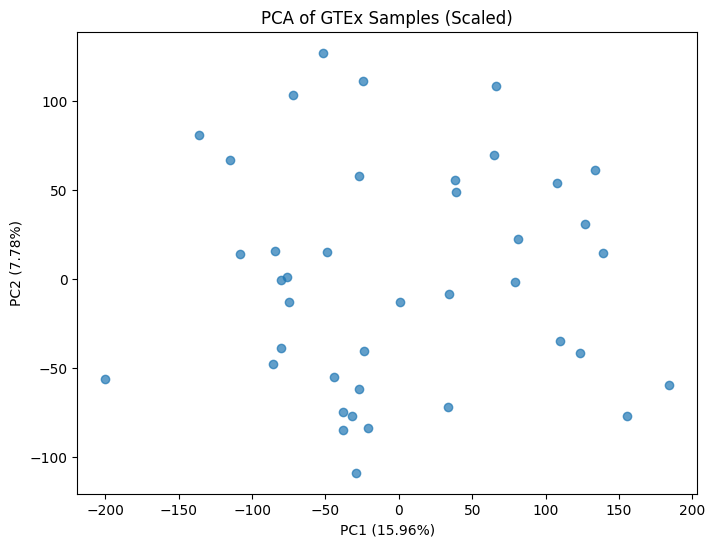

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Transpose to samples × genes
pca_input = gtex_df.T.select_dtypes(include=[np.number])

# Standardize and run PCA
scaler = StandardScaler()
pca_input_scaled = scaler.fit_transform(pca_input)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_input_scaled)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title("PCA of GTEx Samples (Scaled)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.show()

In [ ]:
import os
import pandas as pd

# 1. Create the 'gtex_data' directory if it doesn't exist
os.makedirs('gtex_data', exist_ok=True)

# 2. Assuming 'gtex_df' is your DataFrame after PCA:
# Split the combined DataFrame back into individual sample DataFrames
individual_dfs = [gtex_df[[col]] for col in gtex_df.columns]

# 3. Iterate through the individual DataFrames and save them as CSV files:
for i, df in enumerate(individual_dfs):
    file_path = os.path.join('gtex_data', f'gtexsample_{i+1}.csv')
    df.to_csv(file_path, index=True)  # Save with index (gene names)

# 4. Save the correctly oriented gtex_df to 'combined_gtex.csv'
gtex_df.to_csv(os.path.join('gtex_data', 'combined_gtex.csv'), index=True)

print("Individual CSV files and combined_gtex.csv regenerated in 'gtex_data' directory.")

Individual CSV files and combined_gtex.csv regenerated in 'gtex_data' directory.


In [ ]:
# 1. Import libraries
from google.colab import files
import pandas as pd

# 2. Upload the file from your local machine
uploaded = files.upload()

# 3. Get the uploaded filename
#    (If you uploaded exactly one file, this grabs its name automatically)
filename = list(uploaded.keys())[0]
print(f"Uploaded file: {filename}")

# 4. Read the file into a pandas DataFrame
#    - For a standard CSV, you can use the default sep=','
df = pd.read_csv(filename)

# 5. If your first column is 'gene_name' and you want it as the DataFrame index, do:
# df.set_index('gene_name', inplace=True)

# 6. Preview the first few rows
df.head()


Saving subset_tumor.csv to subset_tumor.csv
Uploaded file: subset_tumor.csv


,gene_name,CGGA_1002,CGGA_1003,CGGA_1010,CGGA_1012,CGGA_1014,CGGA_1017,CGGA_1018,CGGA_103,CGGA_1030,...,CGGA_1097,CGGA_1100,CGGA_1101,CGGA_1103,CGGA_1106,CGGA_1108,CGGA_1111,CGGA_112,CGGA_1120,CGGA_1121
0,A1BG,21,8,13,26,18,26,17,6,16,...,10,7,24,52,6,88,5,53,3,25
1,A1BG-AS1,36,3,19,51,46,48,25,25,30,...,44,27,44,54,22,94,18,56,4,13
2,A1CF,3,2,3,4,1,4,1,0,1,...,0,0,0,15,1,6,4,6,1,0
3,A2M,5968,800,1227,19094,4042,8167,4411,5582,1535,...,7430,827,1052,24501,14952,52593,12609,6064,1120,5556
4,A2M-AS1,7,4,18,6,9,46,9,13,24,...,91,25,217,22,3,173,4,2,7,1


In [ ]:
import os
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

# Install DESeq2 (if not already installed)
utils = importr('utils')
utils.install_packages('BiocManager')  # Install BiocManager if needed
utils.install_packages('DESeq2', repos='https://cloud.r-project.org') # Install DESeq2


# 1. Define paths to input files
# ... (rest of your code)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpgpvrCa/downloaded_packages’

(as ‘lib’ is unspecified)



<rpy2.rinterface_lib.sexp.NULLType object at 0x7ebb8e9ffd90> [0]

In [ ]:
!pip install mygene


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import mygene
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter

###############################################
# 1. Load GTEx Data by Combining 40 CSV Files
###############################################
def load_gtex_data():
    folder = "gtex_data"  # Folder containing gtexsample_*.csv files
    files = [os.path.join(folder, f"gtexsample_{i}.csv") for i in range(1, 41)]
    dfs = []
    for file in files:
        try:
            df = pd.read_csv(file, index_col=0)  # Assume first column (Ensembl IDs) is the index
            # Drop non-numeric 'Description' column if present
            if "Description" in df.columns:
                df = df.drop(columns=["Description"])
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    combined = pd.concat(dfs, axis=1)
    print("Combined GTEx DataFrame shape:", combined.shape)
    return combined

###############################################
# 2. Load Tumor Data
###############################################
def load_tumor_data():
    tumor_file = "subset_tumor.csv"  # Your tumor CSV file
    try:
        tumor_df = pd.read_csv(tumor_file, index_col=0)
        print("Tumor data loaded successfully. Shape:", tumor_df.shape)
    except Exception as e:
        print("Error loading Tumor file:", e)
        raise e
    return tumor_df

###############################################
# 3. Convert Tumor Gene Symbols to Ensembl IDs
###############################################
def convert_gene_to_ensembl(tumor_df):
    """
    Converts the tumor DataFrame index (gene symbols) to Ensembl IDs using mygene.
    """
    mg = mygene.MyGeneInfo()
    gene_symbols = list(tumor_df.index.unique())
    print("Converting", len(gene_symbols), "gene symbols to Ensembl IDs...")
    query_results = mg.querymany(gene_symbols, scopes="symbol", fields="ensembl", species="human")
    mapping_dict = {}
    for result in query_results:
        if "ensembl" in result:
            ens = result["ensembl"]
            # If ensembl is a list, pick the first element and check for 'gene'
            if isinstance(ens, list):
                if "gene" in ens[0]:
                    mapping_dict[result["query"]] = ens[0]["gene"]
            # If it's a dict, use its 'gene' key
            elif isinstance(ens, dict):
                if "gene" in ens:
                    mapping_dict[result["query"]] = ens["gene"]
    print("Mapping dictionary created with", len(mapping_dict), "entries.")
    # Map the tumor DataFrame index (gene symbol) to Ensembl ID.
    tumor_df["ensembl_id"] = tumor_df.index.map(lambda x: mapping_dict.get(x, None))
    # Drop rows where conversion failed.
    tumor_df = tumor_df.dropna(subset=["ensembl_id"]).copy()
    tumor_df = tumor_df.set_index("ensembl_id")
    return tumor_df

###############################################
# 4. Ensure Proper Orientation and Numeric Counts
###############################################
def ensure_orientation_and_numeric(df):
    # Convert every entry to numeric; non-numeric become NaN, then fill with 0 and convert to int.
    df_numeric = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
    # If there are more columns than rows, assume the DataFrame is transposed.
    if df_numeric.shape[0] < df_numeric.shape[1]:
        print("Transposing DataFrame to ensure rows are genes and columns are samples.")
        df_numeric = df_numeric.T
    return df_numeric

###############################################
# 5. Remove Version Numbers from GTEx Ensembl IDs
###############################################
def remove_version_from_index(df):
    def remove_version(x):
        return x.split('.')[0]
    df.index = df.index.map(remove_version)
    return df

###############################################
# 6. Aggregate Duplicate Genes
###############################################
def aggregate_duplicates(df):
    if not df.index.is_unique:
        print(f"Aggregating duplicate gene entries. Original shape: {df.shape}")
        df = df.groupby(df.index).mean()
        print(f"New shape after aggregation: {df.shape}")
    return df

###############################################
# 7. Combine Data Based on Common Genes
###############################################
def combine_data(gtex_df, tumor_df):
    common_genes = gtex_df.index.intersection(tumor_df.index)
    print(f"Found {len(common_genes)} common genes between GTEx and tumor data.")
    gtex_filtered = gtex_df.loc[common_genes]
    tumor_filtered = tumor_df.loc[common_genes]
    combined_df = pd.concat([gtex_filtered, tumor_filtered], axis=1)
    return combined_df

###############################################
# 8. Normalize Combined Data Using DESeq2 via rpy2
###############################################
def normalize_with_deseq2(counts_df):
    # Convert the pandas DataFrame to an R data frame.
    with localconverter(pandas2ri.converter):
        r_counts = pandas2ri.py2rpy(counts_df)

    # Define the DESeq2 normalization function in R.
    r('''
library(DESeq2)
perform_deseq2_normalization <- function(count_data) {
    # Create a sample table (all samples are treated as "control" for normalization)
    colData <- data.frame(condition = rep("control", ncol(count_data)))
    rownames(colData) <- colnames(count_data)

    # Ensure counts are integers by rounding
    count_data <- round(count_data)

    # Create DESeqDataSet object with a simple design (~1)
    dds <- DESeqDataSetFromMatrix(countData = count_data,
                                  colData = colData,
                                  design = ~ 1)
    dds <- DESeq(dds)

    # Get normalized counts
    normCounts <- counts(dds, normalized = TRUE)
    return(normCounts)
}
''')
    # Call the R function.
    normalized_r = r['perform_deseq2_normalization'](r_counts)

    # Convert the result to an R data frame first.
    normalized_r_df = r['as.data.frame'](normalized_r)

    # Then convert the R data frame to a pandas DataFrame.
    with localconverter(pandas2ri.converter):
        normalized_df = pandas2ri.rpy2py(normalized_r_df)

    return normalized_df

###############################################
# 9. Main Function
###############################################
def main():
    # Load data
    gtex_df = load_gtex_data()
    tumor_df = load_tumor_data()

    # Remove version numbers from GTEx IDs
    gtex_df = remove_version_from_index(gtex_df)

    # Convert tumor gene symbols to Ensembl IDs
    tumor_df = convert_gene_to_ensembl(tumor_df)

    # Ensure both datasets have proper orientation and numeric counts
    gtex_df = ensure_orientation_and_numeric(gtex_df)
    tumor_df = ensure_orientation_and_numeric(tumor_df)

    # Aggregate duplicate gene entries
    gtex_df = aggregate_duplicates(gtex_df)
    tumor_df = aggregate_duplicates(tumor_df)

    # Combine datasets on common Ensembl IDs
    combined_df = combine_data(gtex_df, tumor_df)
    print("Combined count matrix shape:", combined_df.shape)

    if combined_df.shape[0] == 0:
        print("No common genes found! Check gene identifier conversion.")
        return

    # Normalize combined data using DESeq2
    normalized_df = normalize_with_deseq2(combined_df)
    print("Normalization complete. Normalized data shape:", normalized_df.shape)

    # Save normalized counts to CSV
    normalized_df.to_csv("normalized_counts.csv", index=True)
    print("Normalized counts saved to normalized_counts.csv")

if __name__ == "__main__":
    main()


Combined GTEx DataFrame shape: (59033, 40)
Tumor data loaded successfully. Shape: (55523, 40)


INFO:biothings.client:querying 1-1000 ...


Converting 55523 gene symbols to Ensembl IDs...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 21001-22000 ...
INFO:biothings.client:querying

Mapping dictionary created with 30295 entries.
Aggregating duplicate gene entries. Original shape: (59033, 40)
New shape after aggregation: (58988, 40)
Aggregating duplicate gene entries. Original shape: (30295, 40)
New shape after aggregation: (30292, 40)
Found 28197 common genes between GTEx and tumor data.
Combined count matrix shape: (28197, 80)




A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 








-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)





Normalization complete. Normalized data shape: (28197, 80)
Normalized counts saved to normalized_counts.csv


Normalized counts shape: (28197, 80)
GTEx data shape: (59033, 40)
Tumor data shape: (55523, 40)
Number of GTEx samples: 40, Number of Tumor samples: 40


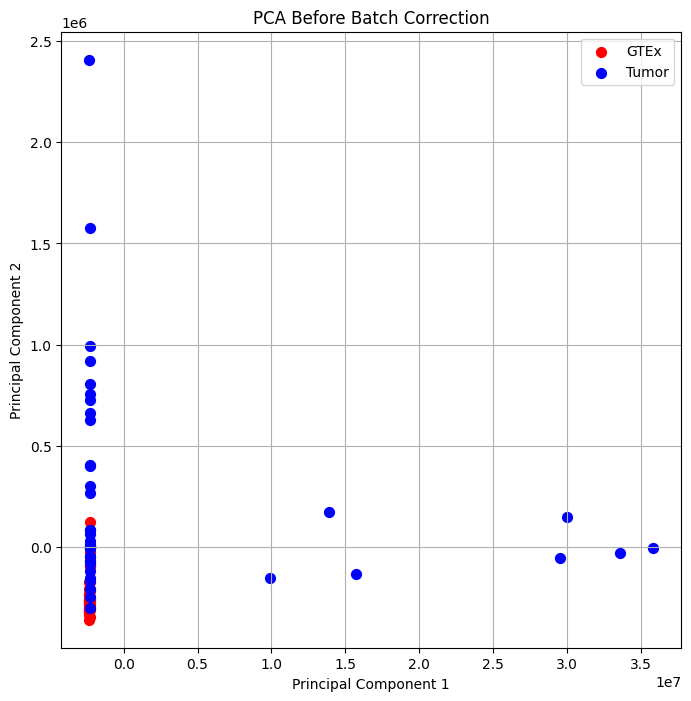

Found 4729 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


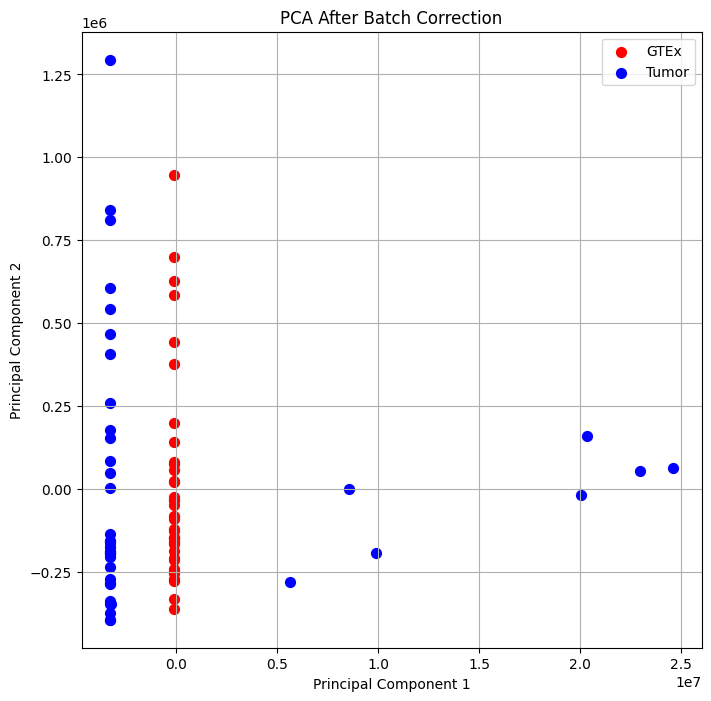

Batch correction complete.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects

# ---------------------------
# 1. Load Normalized Counts Data
# ---------------------------
# This is the output from your DESeq2 normalization step.
normalized_df = pd.read_csv("normalized_counts.csv", index_col=0)
print("Normalized counts shape:", normalized_df.shape)

# ---------------------------
# 2. Load Original GTEx and Tumor Data for Sample Info
# ---------------------------
gtex_file = os.path.join("gtex_data", "combined_gtex.csv")
tumor_file = "subset_tumor.csv"

gtex_df = pd.read_csv(gtex_file, index_col=0)
tumor_df = pd.read_csv(tumor_file, index_col=0)
print("GTEx data shape:", gtex_df.shape)
print("Tumor data shape:", tumor_df.shape)

# Determine how many samples come from each group
num_gtex = gtex_df.shape[1]
num_tumor = tumor_df.shape[1]
print(f"Number of GTEx samples: {num_gtex}, Number of Tumor samples: {num_tumor}")

# ---------------------------
# 3. Create Batch Vector
# ---------------------------
# Assuming the combined normalized matrix columns are ordered as GTEx samples first, then tumor.
batch = np.array([0] * num_gtex + [1] * num_tumor)

# ---------------------------
# 4. PCA Before Batch Correction
# ---------------------------
pca = PCA(n_components=2)
# Transpose so that rows are samples and columns are genes
pca_input = normalized_df.T.select_dtypes(include=[np.number])
pca_result = pca.fit_transform(pca_input)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=pca_input.index)
# Create a label for sample type based on batch
pca_df['sample_type'] = ['GTEx' if b == 0 else 'Tumor' for b in batch]

plt.figure(figsize=(8,8))
for sample, color in zip(['GTEx', 'Tumor'], ['red', 'blue']):
    indices = pca_df['sample_type'] == sample
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'],
                c=color, label=sample, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Before Batch Correction')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 5. Batch Correction Using ComBat via rpy2
# ---------------------------
# Convert the normalized DataFrame to an R data frame.
with localconverter(pandas2ri.converter):
    r_norm = pandas2ri.py2rpy(normalized_df)

# Define the ComBat batch correction function in R.
r('''
library(sva)
perform_combat_batch_correction <- function(data, batch) {
    mod <- model.matrix(~1, data = data.frame(batch))
    combat_data <- ComBat(dat = data, batch = batch, mod = mod, par.prior=TRUE, ref.batch = NULL)
    return(as.data.frame(combat_data))
}
''')

# Convert the Python batch vector to an R vector.
r_batch = robjects.FloatVector(batch)

# Run ComBat batch correction.
combat_corrected_r = r['perform_combat_batch_correction'](r_norm, r_batch)

# Convert the corrected R data frame back to a pandas DataFrame.
with localconverter(pandas2ri.converter):
    combat_corrected_df = pandas2ri.rpy2py(combat_corrected_r)

# ---------------------------
# 6. PCA After Batch Correction
# ---------------------------
pca_after = PCA(n_components=2)
pca_input_after = combat_corrected_df.T.select_dtypes(include=[np.number])
pca_result_after = pca_after.fit_transform(pca_input_after)
pca_df_after = pd.DataFrame(pca_result_after, columns=['PC1', 'PC2'], index=pca_input_after.index)
pca_df_after['sample_type'] = ['GTEx' if b == 0 else 'Tumor' for b in batch]

plt.figure(figsize=(8,8))
for sample, color in zip(['GTEx', 'Tumor'], ['red', 'blue']):
    indices = pca_df_after['sample_type'] == sample
    plt.scatter(pca_df_after.loc[indices, 'PC1'], pca_df_after.loc[indices, 'PC2'],
                c=color, label=sample, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA After Batch Correction')
plt.legend()
plt.grid(True)
plt.show()

print("Batch correction complete.")


In [ ]:
import pandas as pd
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as robjects

# ---------------------------
# 1. Create Sample Metadata for DE Analysis
# ---------------------------
# Assuming that your batch vector is defined as:
#   batch = np.array([0]*num_gtex + [1]*num_tumor)
# and that combat_corrected_df is your batch-corrected normalized counts DataFrame.
# Also, assume that columns in combat_corrected_df are ordered such that
# the first num_gtex columns correspond to GTEx (normal) and the next num_tumor columns correspond to Tumor.

# Recreate your batch vector if needed (using the same numbers as before)
# (Here, we assume these values are still available or recompute based on your data dimensions)
num_gtex = gtex_df.shape[1]  # from your original GTEx combined data (before combining with tumor)
num_tumor = tumor_df.shape[1]  # from your tumor file
batch = [ "GTEx" ] * num_gtex + [ "Tumor" ] * num_tumor

# Create a metadata DataFrame for samples (use column names from the corrected data)
sample_names = combat_corrected_df.columns
metadata_df = pd.DataFrame({'sample_type': batch}, index=sample_names)
print("Sample metadata (first 5 rows):")
print(metadata_df.head())

# ---------------------------
# 2. Convert Data to R Objects Using rpy2
# ---------------------------
with localconverter(pandas2ri.converter):
    r_counts = pandas2ri.py2rpy(combat_corrected_df)
    r_metadata = pandas2ri.py2rpy(metadata_df)

# ---------------------------
# 3. Run Differential Expression Analysis in R using DESeq2 (with shifting)
# ---------------------------
# Define and run an R function to perform DESeq2 analysis.
r('''
library(DESeq2)
run_deseq2 <- function(counts, colData) {
    # Ensure that sample_type is a factor and set GTEx as the reference level.
    colData$sample_type <- factor(colData$sample_type)
    colData$sample_type <- relevel(colData$sample_type, ref = "GTEx")

    # Shift counts if there are negative values
    if(min(counts) < 0) {
        counts <- counts - min(counts) + 1
    }

    # Create the DESeqDataSet object. (DESeq2 expects raw counts, so we round the input.)
    dds <- DESeqDataSetFromMatrix(countData = round(counts),
                                  colData = colData,
                                  design = ~ sample_type)
    dds <- DESeq(dds)

    # Extract results: compare Tumor vs GTEx.
    res <- results(dds, contrast=c("sample_type", "Tumor", "GTEx"))
    resOrdered <- res[order(res$padj), ]
    return(as.data.frame(resOrdered))
}
''')

# Run the function from Python.
deseq2_results_r = r['run_deseq2'](r_counts, r_metadata)

# Convert DESeq2 results back to a pandas DataFrame.
with localconverter(pandas2ri.converter):
    deseq2_results_df = pandas2ri.rpy2py(deseq2_results_r)

print("Differential expression analysis complete. Results shape:", deseq2_results_df.shape)
print("Top DE genes:")
print(deseq2_results_df.head())

# Save DESeq2 results to CSV.
deseq2_results_df.to_csv("deseq2_results.csv", index=True)
print("DESeq2 results saved to 'deseq2_results.csv'")

# ---------------------------
# 4. Convert DESeq2 Results Back to a Pandas DataFrame
# ---------------------------
with localconverter(pandas2ri.converter):
    deseq2_results_df = pandas2ri.rpy2py(deseq2_results_r)

print("Differential expression analysis complete. Results shape:", deseq2_results_df.shape)
print("Top DE genes:")
print(deseq2_results_df.head())

# ---------------------------
# 5. Save DESeq2 Results to CSV
# ---------------------------
deseq2_results_df.to_csv("deseq2_results.csv", index=True)
print("DESeq2 results saved to 'deseq2_results.csv'")


Sample metadata (first 5 rows):
   sample_type
V1        GTEx
V2        GTEx
V3        GTEx
V4        GTEx
V5        GTEx







   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.





Differential expression analysis complete. Results shape: (28197, 6)
Top DE genes:
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
25864  885827.824875       -0.019261  0.000793 -24.294764  2.226765e-130   
11325  883580.874307       -0.011973  0.000516 -23.214096  3.280859e-119   
24051  882193.148982       -0.007453  0.000374 -19.911314   3.246864e-88   
8157   881791.148884       -0.006141  0.000366 -16.759884   4.795557e-63   
26017  881548.873835       -0.005349  0.000452 -11.827083   2.828001e-32   

                padj  
25864  6.278810e-126  
11325  4.625519e-115  
24051   3.051728e-84  
8157    3.380508e-59  
26017   1.594823e-28  
DESeq2 results saved to 'deseq2_results.csv'
Differential expression analysis complete. Results shape: (28197, 6)
Top DE genes:
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
25864  885827.824875       -0.019261  0.000793 -24.294764  2.226765e-130   
11325  883580.874307       -0.011973  0.00

In [ ]:
!Rscript -e "if (!requireNamespace('BiocManager', quietly = TRUE)) install.packages('BiocManager'); BiocManager::install('org.Hs.eg.db')"


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)
Installing package(s) 'org.Hs.eg.db'
trying URL 'https://bioconductor.org/packages/3.20/data/annotation/src/contrib/org.Hs.eg.db_3.20.0.tar.gz'
Content type 'application/x-gzip' length 98233708 bytes (93.7 MB)
downloaded 93.7 MB

* installing *source* package ‘org.Hs.eg.db’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (org.Hs.eg.db)

The downloaded source packages are in
	‘/tmp/RtmpYXLltR/downloa

In [ ]:
print(deseq2_results.head())


            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
25864  885827.824875       -0.019261  0.000793 -24.294764  2.226765e-130   
11325  883580.874307       -0.011973  0.000516 -23.214096  3.280859e-119   
24051  882193.148982       -0.007453  0.000374 -19.911314   3.246864e-88   
8157   881791.148884       -0.006141  0.000366 -16.759884   4.795557e-63   
26017  881548.873835       -0.005349  0.000452 -11.827083   2.828001e-32   

                padj  
25864  6.278810e-126  
11325  4.625519e-115  
24051   3.051728e-84  
8157    3.380508e-59  
26017   1.594823e-28  


In [ ]:
# ---------------------------
# Required Libraries
# ---------------------------
import os
import pandas as pd
import numpy as np
import mygene
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter, py2rpy, rpy2py # Import rpy2py explicitly
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# Install mygene if not already installed
try:
    import mygene
except ImportError:
    print("Installing mygene...")
    !pip install mygene --quiet
    import mygene

# Activate pandas DataFrame conversion for rpy2
pandas2ri.activate()

# ---------------------------
# Configuration (MODIFY THESE)
# ---------------------------
deseq2_results_file = "deseq2_results.csv" # INPUT: Path to your DESeq2 results CSV
output_prefix = "enrichment_results"       # Prefix for output PDF plot files
go_output_csv = "GO_enrichment_results.csv"    # OUTPUT: GO results CSV
kegg_output_csv = "KEGG_enrichment_results.csv"  # OUTPUT: KEGG results CSV

padj_threshold = 0.05
lfc_threshold = 1.0
fallback_top_n_genes = 100 # Use top N genes if no significant genes found by thresholds
target_species = "human"   # Or "mouse", etc. used by mygene
kegg_organism_code = "hsa" # Human KEGG code. Change if species is different (e.g., "mmu" for mouse)

# ---------------------------
# 1. Load DESeq2 Results and Filter Genes
# ---------------------------
print(f"Loading DESeq2 results from: {deseq2_results_file}")
try:
    # Ensure the first column (gene IDs) is used as the index
    deseq2_results = pd.read_csv(deseq2_results_file, index_col=0)
except FileNotFoundError:
    print(f"ERROR: DESeq2 results file not found at {deseq2_results_file}")
    # --- Create dummy data if file not found (for testing) ---
    print("Creating dummy DESeq2 results for demonstration...")
    genes = [f'GeneSymbol_{i}' for i in range(500)] + [f'ENSG{i:011d}' for i in range(500)]
    dummy_data = {
        'baseMean': np.random.rand(1000) * 1000,
        'log2FoldChange': np.random.normal(0, 1.5, 1000),
        'lfcSE': np.random.rand(1000) * 0.5,
        'stat': np.random.normal(0, 3, 1000),
        'pvalue': np.random.uniform(0, 1, 1000),
        'padj': np.random.uniform(0, 1, 1000)
    }
    deseq2_results = pd.DataFrame(dummy_data, index=genes)
    sig_idx = np.random.choice(deseq2_results.index, 150, replace=False)
    deseq2_results.loc[sig_idx[:75], 'log2FoldChange'] = np.random.uniform(1.1, 3, 75)
    deseq2_results.loc[sig_idx[75:], 'log2FoldChange'] = np.random.uniform(-3, -1.1, 75)
    deseq2_results.loc[sig_idx, 'padj'] = np.random.uniform(0, 0.04, 150)
    deseq2_results.loc[sig_idx, 'pvalue'] = np.random.uniform(0, 0.01, 150)
    deseq2_results = deseq2_results.sort_values('pvalue')
    # --- End dummy data ---

print("DESeq2 results shape:", deseq2_results.shape)

# Filter for significant genes
print(f"\nFiltering for significant genes (padj < {padj_threshold} & |log2FC| > {lfc_threshold})...")
sig_genes = deseq2_results[
    (deseq2_results['padj'] < padj_threshold) &
    (abs(deseq2_results['log2FoldChange']) > lfc_threshold)
].copy() # Use copy to avoid SettingWithCopyWarning

if sig_genes.empty:
    print(f"No significant DE genes found using strict criteria (padj < {padj_threshold}, |log2FC| > {lfc_threshold}).")
    print(f"Selecting top {fallback_top_n_genes} genes by p-value as fallback.")
    sig_genes = deseq2_results.sort_values("pvalue").head(fallback_top_n_genes).copy()
    if sig_genes.empty:
        raise ValueError("No genes found in DESeq2 results, even for fallback.")

print(f"Number of genes selected for enrichment analysis: {sig_genes.shape[0]}")
if sig_genes.shape[0] < 10:
     print("WARNING: Very few genes selected for enrichment. Results may not be meaningful.")

# ---------------------------
# 2. Check Gene Identifiers and Map If Needed (to Entrez IDs)
# ---------------------------
gene_list = list(sig_genes.index)
print("\nFirst 10 gene identifiers from results:", gene_list[:10])

try:
    first_id_str = str(gene_list[0]).split(':')[-1]
    _ = int(first_id_str)
    are_entrez = True
    print("Gene identifiers appear to be numeric (assuming Entrez IDs).")
    mapping_dict = {}
    valid_entrez_count = 0
    for gene in gene_list:
       try:
           entrez_id = int(str(gene).split(':')[-1])
           mapping_dict[gene] = entrez_id
           valid_entrez_count += 1
       except ValueError:
           print(f"  Warning: Could not convert assumed Entrez ID '{gene}' to integer. Skipping.")
    print(f"Successfully converted {valid_entrez_count} assumed Entrez IDs.")

except (ValueError, IndexError):
    are_entrez = False
    print(f"Gene identifiers do not appear to be numeric Entrez IDs. Attempting mapping using MyGene.info for species '{target_species}'...")
    mg = mygene.MyGeneInfo()
    query_results = mg.querymany(gene_list, scopes="symbol,alias,ensembl.gene", fields="entrezgene",
                                 species=target_species, returnall=True, size=1000, verbose=False)

    mapping_dict = {}
    mapped_count = 0
    unmapped_genes = []

    for result in query_results.get('out', []):
        query_gene = result.get('query')
        entrez_id = result.get('entrezgene')
        not_found = result.get('notfound', False)

        if query_gene and entrez_id and not not_found:
            if isinstance(entrez_id, list):
                entrez_id = entrez_id[0]
            try:
               mapping_dict[query_gene] = int(entrez_id)
               mapped_count += 1
            except (ValueError, TypeError):
               print(f"  Warning: Found Entrez ID '{entrez_id}' for '{query_gene}', but couldn't convert to int. Skipping.")
        elif query_gene:
            unmapped_genes.append(query_gene)

    print(f"Mapped {mapped_count} out of {len(gene_list)} genes to Entrez IDs.")
    if mapped_count == 0:
        raise ValueError("No genes were mapped to Entrez IDs. Check input gene ID format, species, or enrichment thresholds.")
    if unmapped_genes:
        print(f"Could not map {len(unmapped_genes)} genes. First few unmapped: {unmapped_genes[:10]}")

sig_genes['entrez_id'] = sig_genes.index.map(mapping_dict.get)
original_count = sig_genes.shape[0]
sig_genes = sig_genes.dropna(subset=['entrez_id']).copy()
sig_genes['entrez_id'] = sig_genes['entrez_id'].astype(int)
dropped_count = original_count - sig_genes.shape[0]

print(f"Removed {dropped_count} genes that could not be mapped to Entrez IDs.")
print(f"Final number of genes with Entrez IDs for enrichment: {sig_genes.shape[0]}")

if sig_genes.empty:
    raise ValueError("No genes remaining after mapping to Entrez IDs. Cannot proceed with enrichment.")

entrez_ids = list(sig_genes['entrez_id'])
r_entrez_ids = robjects.IntVector(entrez_ids)
print(f"First 10 Entrez IDs being passed to R: {entrez_ids[:10]}")

# ---------------------------
# 3. Install/Load Required R Packages
# ---------------------------
print("\nChecking/Installing required R packages...")

# Set the Python variable into the R global environment
robjects.globalenv['target_species_r'] = robjects.StrVector([target_species])

r('''
install_if_missing <- function(pkg, repo=c("CRAN", "Bioconductor")) {
  repo <- match.arg(repo)
  if (!requireNamespace(pkg, quietly = TRUE)) {
    message(paste("Installing", pkg, "..."))
    if (repo == "Bioconductor") {
      if (!requireNamespace("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager", quiet = TRUE, repos = "https://cloud.r-project.org/")
      }
      BiocManager::install(pkg, update=FALSE, ask=FALSE)
    } else {
      install.packages(pkg, quiet = TRUE, repos = "https://cloud.r-project.org/")
    }
  } else {
    # message(paste(pkg, "is already installed."))
  }
  # Load the library after ensuring installation
  library(pkg, character.only = TRUE)
}

# Determine OrgDb package based on species
get_orgdb_pkg <- function(species_lower) {
    if (species_lower == 'human') {
        return("org.Hs.eg.db")
    } else if (species_lower == 'mouse') {
        return("org.Mm.eg.db")
    } # Add other organisms here, e.g.:
    # else if (species_lower == 'rat') {
    #     return("org.Rn.eg.db")
    # }
      else {
        stop(paste("Unsupported species for automatic OrgDb selection:", species_lower))
    }
}

# Get OrgDb package name from Python variable
orgdb_package_name <- get_orgdb_pkg(tolower(target_species_r)) # Use variable passed from Python

required_pkgs <- list()
required_pkgs[[orgdb_package_name]] <- "Bioconductor"
required_pkgs[["clusterProfiler"]] <- "Bioconductor"

# Loop through and install/load
for (pkg_name in names(required_pkgs)) {
  install_if_missing(pkg_name, repo = required_pkgs[[pkg_name]])
}

message("Required R packages checked/loaded.")
''')

orgdb_package = r('orgdb_package_name')[0] # Get determined package name back from R
print(f"Using R OrgDb package: {orgdb_package}")

# ---------------------------
# 4. Define and Run the Enrichment Analysis Function in R
# ---------------------------
print("\nDefining and running enrichment analysis function in R...")

# Define the R function as a string
r_enrichment_func_def = f'''
# Ensure libraries are loaded in this environment
library(clusterProfiler)
library({orgdb_package}) # Load the correct organism database

perform_enrichment <- function(entrez_ids, orgdb_pkg_name_arg, kegg_org_code, output_prefix) {{
    # Convert to character for safety, especially KEGG
    entrez_ids_char <- as.character(entrez_ids)
    entrez_ids_num <- as.numeric(entrez_ids_char) # enrichGO often prefers numeric

    message("Starting GO enrichment (Biological Process)...")
    go_bp <- NULL
    tryCatch({{
        go_bp <- enrichGO(
          gene          = entrez_ids_num, # Use numeric for enrichGO
          OrgDb         = get(orgdb_pkg_name_arg), # Use package name variable
          keyType       = "ENTREZID",
          ont           = "BP",
          pAdjustMethod = "BH",
          pvalueCutoff  = 0.05,
          qvalueCutoff  = 0.20
        )
        message("GO enrichment completed.")
    }}, error = function(e) {{
        message("GO enrichment failed: ", conditionMessage(e))
    }})

    go_df <- if (!is.null(go_bp) && nrow(as.data.frame(go_bp)) > 0) as.data.frame(go_bp) else {{message("No significant GO terms."); data.frame()}}

    message("\\nStarting KEGG enrichment...")
    kegg <- NULL
    tryCatch({{
        kegg <- enrichKEGG(
          gene          = entrez_ids_char, # Use character for KEGG
          organism      = kegg_org_code,
          pAdjustMethod = "BH",
          pvalueCutoff  = 0.05,
          qvalueCutoff  = 0.20
        )
        message("KEGG enrichment completed.")
    }}, error = function(e) {{
        message("KEGG enrichment failed: ", conditionMessage(e))
        if(grepl("HTTP error|download|URL", conditionMessage(e), ignore.case = TRUE)) {{
          message("  (This might be due to internet connection issues required for KEGG.)")
        }}
    }})

    kegg_df <- if (!is.null(kegg) && nrow(as.data.frame(kegg)) > 0) as.data.frame(kegg) else {{message("No significant KEGG pathways."); data.frame()}}

    # Generate plots (saving to current directory)
    if(!is.null(go_bp) && nrow(go_df) > 0) {{
        tryCatch({{
            go_plot_file <- paste0(output_prefix, "_GO_dotplot.pdf")
            pdf(go_plot_file, width=12, height=max(8, min(25, nrow(go_df))*0.35)) # Adjust height, max 25 terms
            print(dotplot(go_bp, showCategory=min(30, nrow(go_df)), title="GO Biological Process Enrichment"))
            dev.off()
            message(paste("  GO dotplot saved to", go_plot_file))
        }}, error = function(e) {{ message("  Failed to create GO plot: ", conditionMessage(e)) }})
    }}

    if(!is.null(kegg) && nrow(kegg_df) > 0) {{
         tryCatch({{
            kegg_plot_file <- paste0(output_prefix, "_KEGG_dotplot.pdf")
            pdf(kegg_plot_file, width=12, height=max(8, min(25, nrow(kegg_df))*0.35))
            print(dotplot(kegg, showCategory=min(30, nrow(kegg_df)), title="KEGG Pathway Enrichment"))
            dev.off()
            message(paste("  KEGG dotplot saved to", kegg_plot_file))
        }}, error = function(e) {{ message("  Failed to create KEGG plot: ", conditionMessage(e)) }})
    }}

    return(list(go_bp = go_df, kegg = kegg_df))
}}
'''

# Execute the R code string to define the function in R's global environment
r(r_enrichment_func_def)

# Run the R function
print(f"\nRunning R perform_enrichment function with {len(entrez_ids)} Entrez IDs...")
enrichment_results = r['perform_enrichment'](
    r_entrez_ids,
    robjects.StrVector([orgdb_package]), # Pass OrgDb name as string vector
    robjects.StrVector([kegg_organism_code]), # Pass KEGG code as string vector
    robjects.StrVector([output_prefix]) # Pass prefix as string vector
)
print("R function execution finished.")

# ---------------------------
# 5. Convert R Results Back to Pandas DataFrames
# ---------------------------
print("\nConverting R results back to pandas DataFrames...")

# Access list elements from R
r_go_result = enrichment_results.rx2('go_bp')
r_kegg_result = enrichment_results.rx2('kegg')

# Use default rpy2 conversion (handles data frames well)
try:
    go_bp_df = rpy2py(r_go_result) # Use imported rpy2py
    kegg_df = rpy2py(r_kegg_result)

    # Ensure they are DataFrames
    if not isinstance(go_bp_df, pd.DataFrame):
        go_bp_df = pd.DataFrame()
    if not isinstance(kegg_df, pd.DataFrame):
        kegg_df = pd.DataFrame()

except Exception as e:
    print("Error during R-to-Python conversion:", e)
    print("Raw R GO result object type:", type(r_go_result))
    print(r_go_result)
    print("\nRaw R KEGG result object type:", type(r_kegg_result))
    print(r_kegg_result)
    raise e

print("\n--- GO Enrichment Results ---")
if go_bp_df.empty:
    print("No significant GO enrichment results found or returned.")
else:
    go_bp_df = go_bp_df.sort_values(by='p.adjust')
    print(go_bp_df.head())
    go_bp_df.to_csv(go_output_csv, index=False)
    print(f"\nGO results saved to {go_output_csv}")

print("\n--- KEGG Enrichment Results ---")
if kegg_df.empty:
    print("No significant KEGG enrichment results found or returned.")
else:
    kegg_df = kegg_df.sort_values(by='p.adjust')
    print(kegg_df.head())
    kegg_df.to_csv(kegg_output_csv, index=False)
    print(f"\nKEGG results saved to {kegg_output_csv}")

print("\nEnrichment analysis complete. Check CSV files and PDF plots (if generated).")

Loading DESeq2 results from: deseq2_results.csv
DESeq2 results shape: (28197, 6)

Filtering for significant genes (padj < 0.05 & |log2FC| > 1.0)...
No significant DE genes found using strict criteria (padj < 0.05, |log2FC| > 1.0).
Selecting top 100 genes by p-value as fallback.
Number of genes selected for enrichment analysis: 100

First 10 gene identifiers from results: [25864, 11325, 24051, 8157, 26017, 18636, 16685, 13010, 24015, 13575]
Gene identifiers appear to be numeric (assuming Entrez IDs).
Successfully converted 100 assumed Entrez IDs.
Removed 0 genes that could not be mapped to Entrez IDs.
Final number of genes with Entrez IDs for enrichment: 100
First 10 Entrez IDs being passed to R: [25864, 11325, 24051, 8157, 26017, 18636, 16685, 13010, 24015, 13575]

Checking/Installing required R packages...


Using R OrgDb package: org.Hs.eg.db

Defining and running enrichment analysis function in R...

Running R perform_enrichment function with 100 Entrez IDs...





Starting KEGG enrichment...





R function execution finished.

Converting R results back to pandas DataFrames...

--- GO Enrichment Results ---
No significant GO enrichment results found or returned.

--- KEGG Enrichment Results ---
No significant KEGG enrichment results found or returned.

Enrichment analysis complete. Check CSV files and PDF plots (if generated).
